# Install

In [1]:
! pip install fastai2 -q

     |████████████████████████████████| 194kB 2.8MB/s 


# Import

In [0]:
from fastai2.data.external import untar_data, URLs
from fastai2.data.transforms import get_image_files

# Dataset

In [4]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
len(files), files[0]

(7390, Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_116.jpg'))

# Preparing Data

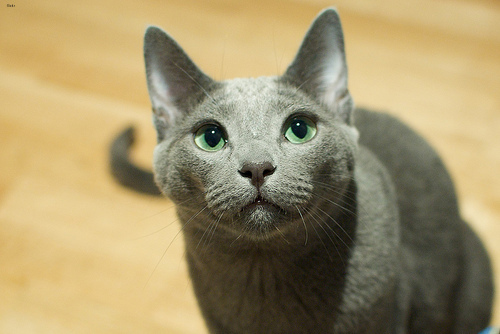

In [6]:
import PIL
img = PIL.Image.open(files[0])
img

In [0]:
import torch
import numpy as np

## Open image files

In [0]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2, 0, 1).float()/255.0

In [63]:
t = open_image(files[0])
t.shape

torch.Size([3, 224, 224])

## Labeling

In [0]:
import re

In [0]:
def label_func(fname):
    return re.match(r'^(.*)_\d+\.jpg$', fname.name).groups()[0]

In [66]:
l = label_func(files[0])
l

'Russian_Blue'

In [67]:
labels = list(set(files.map(label_func)))
len(labels)

37

## Creating util dict

In [0]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [0]:
# lbl2files

# Creating Custom Dataset

In [0]:
import random

## Define SiameseDataset class

In [0]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]), same

    def __getitem__(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())

    def __len__(self):
        return len(self.files)

## Split

เอาเลข Running ตามจำนวนไฟล์ มา สับไพ่ Random แล้วเลือกตัดเป็น 2 ส่วน 80/20 นำมาใช้ดึงรายการไฟล์ใส่ Training Set / Validation Set

In [0]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

นำข้อมูลรายการไฟล์ที่ได้ มาสร้าง Dataset 2 SiameseDataset

In [0]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

# DataLoaders

ใช้ 2 Dataset ที่ได้มาสร้าง DataLoaders

In [0]:
from fastai2.data.core import DataLoaders

In [75]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)
dls

เรายังเรียก show_batch ไม่ได้ เพราะยังไม่ได้กำหนดวิธีแสดงผล เราจะลองดึงข้อมูลดู ด้วย one_batch

In [0]:
b = dls.one_batch()
# b

ถ้าต้องการให้ DataLoaders ของเรา ย้ายข้อมูลไปใช้ GPU ก็เพียงแค่สั่ง

In [60]:
dls.cuda()

# Transform

ในวิธีการเดียวกันกับที่เราสร้าง SiameseDataset เราสามารถนำมาสร้าง Transform เพื่อใช้ใน Data Pipeline สำหรับป้อนให้โมเดล

In [0]:
from fastai2.vision.all import *

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
    
    def encodes(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (TensorImage(img1), TensorImage(img2), Tensor([same]).squeeze())

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]), same

In [0]:
train_tl = TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl = TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [0]:
# train_tl

In [0]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
# dls

In [95]:
dls.cuda()

# Credit 

* https://dev.fast.ai/tutorial.siamese